In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import ascii

BANDS = ['g', 'r', 'i']
UPPER_LIMIT_MAGS = {
    'pstarr' : {'g': 23.3, 'r': 23.2, 'i': 23.1},
    'ztf': {'g': 23.3, 'r': 23.2, 'i': 23.1}
}
ZTF_ZERO_POINT = {
    'g': 26.325,
    'r': 26.275,
    'i': 25.66
}

In [2]:
from typing import Optional

def img_ab_mag_to_flux(mag: np.ndarray, zero_point: np.ndarray, magerr: Optional[np.ndarray] = None) -> np.ndarray:
    """Inverse of img_flux_to_ab_mag."""
    flux = 10 ** ((mag - zero_point) / -2.5)
    if magerr is not None:
        fluxerr = (magerr * (np.log(10) * flux)) / 2.5
        return flux, fluxerr
    return flux

def get_snr_from_mag(mag, magerr, zp):
        flux, fluxerr = img_ab_mag_to_flux(mag, zero_point=zp, magerr=magerr)
        return flux / fluxerr

# Look at one field (000513)

In [62]:
test = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000513_g.ecsv')

In [3]:
g_tab = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000513_g.ecsv')
r_tab = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000513_r.ecsv')
i_tab = ascii.read('/Users/adamboesky/Research/long_transients/Data/catalog_results/field_results/000513_i.ecsv')
tables = {'g': g_tab, 'r': r_tab, 'i': i_tab}
print(len(g_tab), len(r_tab), len(i_tab))
g_tab

273510 274171 274714


ra,dec,ZTF_thresh,ZTF_npix,ZTF_tnpix,ZTF_xmin,ZTF_xmax,ZTF_ymin,ZTF_ymax,ZTF_x,ZTF_y,ZTF_x2,ZTF_y2,ZTF_xy,ZTF_errx2,ZTF_erry2,ZTF_errxy,ZTF_a,ZTF_b,ZTF_theta,ZTF_cxx,ZTF_cyy,ZTF_cxy,ZTF_cflux,ZTF_flux,ZTF_cpeak,ZTF_peak,ZTF_xcpeak,ZTF_ycpeak,ZTF_xpeak,ZTF_ypeak,ZTF_flag,ZTF_gKronMag,ZTF_gKronMagErr,ZTF_gKronCircleFlag,ZTF_gPSFMag,ZTF_gPSFMagErr,ZTF_gPSFFlags,ZTF_ra,ZTF_dec,PSTARR_PanSTARR_ID,PSTARR_gKronMag,PSTARR_rKronMag,PSTARR_iKronMag,PSTARR_gKronMagErr,PSTARR_rKronMagErr,PSTARR_iKronMagErr,PSTARR_gApMag,PSTARR_rApMag,PSTARR_iApMag,PSTARR_gApMagErr,PSTARR_rApMagErr,PSTARR_iApMagErr,PSTARR_gPSFMag,PSTARR_rPSFMag,PSTARR_iPSFMag,PSTARR_gPSFMagErr,PSTARR_rPSFMagErr,PSTARR_iPSFMagErr,PSTARR_primaryDetection,PSTARR_ra,PSTARR_dec,association_separation_arcsec,Catalog
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6
97.08175275011205,13.558841024064002,0.9287290573120117,7.0,2.0,1065.0,1067.0,70.0,72.0,1066.3556047543802,71.0,0.39882014701680024,0.4575824665064092,0.0,0.021989655853524134,0.025400814595003693,0.0,0.676448404788971,0.6315220594406128,1.5707963705062866,2.5073959827423096,2.1853983402252197,-0.0,11.670082092285156,14.240066528320312,2.770040512084961,7.920257568359375,1066.0,71.0,1066.0,71.0,0.0,20.477273016866356,0.04268176268535784,0.0,21.485337664068986,0.0903808402919347,0.0,97.0817481600423,13.558720000465804,1.2427097081757125e+17,21.7108001708984,20.0816993713379,18.9260005950928,0.0742729976773262,0.0174209997057915,0.0113340001553297,21.7171001434326,20.0067005157471,18.82080078125,0.00771200004965067,0.00310100009664893,0.00224600010551512,21.3598003387451,19.878999710083,19.1287002563477,0.0427640005946159,0.0105050001293421,0.00946800038218498,1.0,97.0817573401818,13.5589620476622,0.8719619754232865,Both
97.44212218781374,13.563271349650456,0.9287290573120117,18.0,3.0,2325.0,2330.0,71.0,73.0,2327.440934763151,72.0,1.7925239054181628,0.5,0.0,0.002047546879405049,0.00046849798767972865,0.0,1.3388516902923584,0.7071067690849304,0.0,0.5578725934028625,2.0,-0.0,149.5594940185547,149.5594940185547,21.605365753173828,71.33894348144531,2327.0,72.0,2327.0,72.0,0.0,17.338536263864338,0.003820717182574529,0.0,19.290694560494863,0.00799309585345683,0.0,97.44205679964509,13.563082213966714,1.2427097442190666e+17,18.2359008789063,17.3799991607666,16.9552993774414,0.00417899992316961,0.00182699994184077,0.00220200000330806,18.1322002410889,17.3020000457764,16.863000869751,0.00164200004655868,0.000987999956123531,0.00100899999961257,18.1147003173828,17.3232002258301,16.9090995788574,0.00406000018119812,0.00165800005197525,0.00193100003525615,1.0,97.4421875759824,13.5634604853342,1.4366258051531453,Both
97.04874471319218,13.558118576438414,0.9287290573120117,15.0,4.0,948.0,952.0,70.0,74.0,950.6340909903331,71.44722348113501,0.8986186341760369,1.0175692657058346,-0.3890000123046571,0.005311659291051615,0.005765293414130344,-0.0021865783947944695,1.1625895500183105,0.7513810992240906,-0.8612571358680725,1.3334927558898926,1.1776117086410522,1.0195447206497192,57.73281478881836,61.999908447265625,10.456466674804688,41.82586669921875,951.0,71.0,951.0,71.0,0.0,18.297689136522685,0.008338856714872842,0.0,19.638698106201687,0.012045600527780078,0.0,97.04868801609705,13.55814414664663,1.2427097048803019e+17,20.0988998413086,19.3512992858887,18.7915000915527,0.0184969995170832,0.010584999807179,0.0079950001090765,19.9953994750977,19.2605991363525,18.6604995727539,0.00349000003188849,0.00219899998046458,0.0020860000513494,20.0611000061035,19.2215995788574,18.7252006530762,0.01453

In [69]:
for k in g_tab.colnames:
    if 'flag' in k.lower():
        print(k)

ZTF_flag
ZTF_gKronCircleFlag
ZTF_gPSFFlags


In [4]:
# Set values <=0 to the upper limit for ZTF
for band in BANDS:
    tab = tables[band]
    upper_lim_mask = tab[f'ZTF_{band}PSFFlags'] == 4
    tab[f'ZTF_{band}PSFMag'][upper_lim_mask] = UPPER_LIMIT_MAGS['ztf'][band]   # 4 means flux was negative
    tab[f'ZTF_{band}_upper_lim'] = False
    tab[f'ZTF_{band}_upper_lim'][upper_lim_mask] = True
    tables[band] = tab

In [61]:
np.unique(tab[f'PSTARR_iPSFMagErr'][tab[f'PSTARR_iPSFMagErr'] <= 0])

-999.0


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_71277/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_71277/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


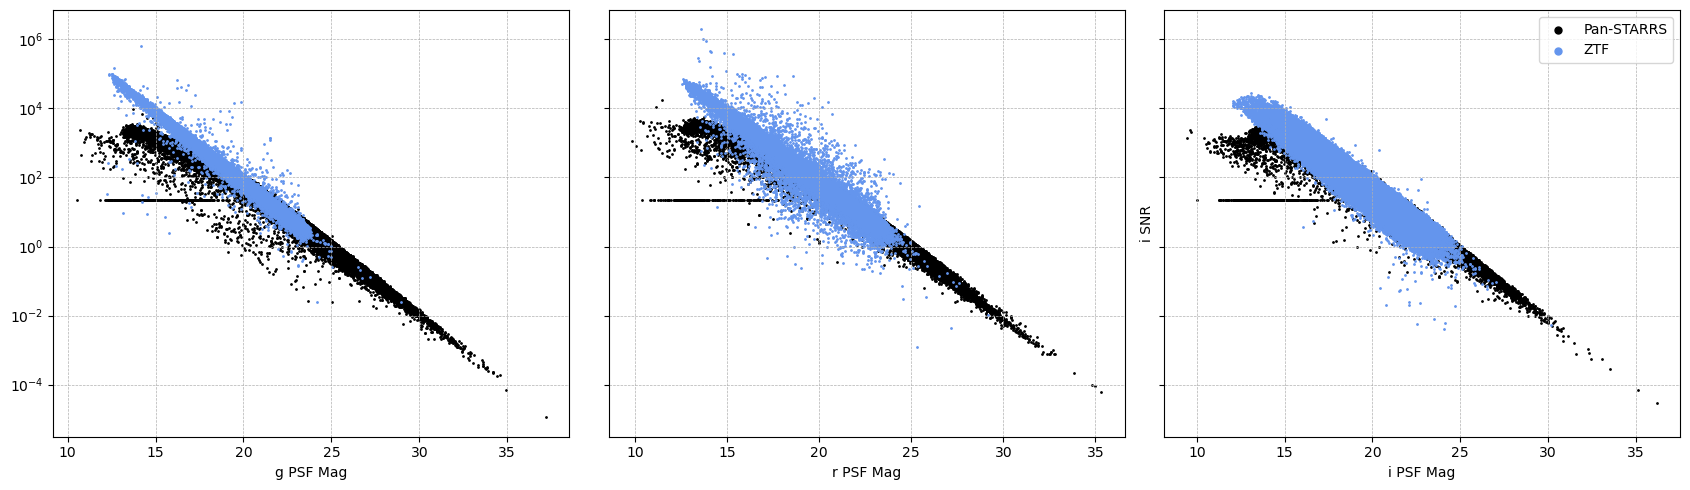

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=ZTF_ZERO_POINT[band])

    # Plot
    ax.scatter(tab[f'PSTARR_{band}PSFMag'], pstarr_snr, color='k', label='Pan-STARRS', s=1)
    ax.scatter(tab[f'ZTF_{band}PSFMag'], ztf_snr, color='cornflowerblue', label='ZTF', s=1)

    # Formatting
    ax.set_yscale('log')
    ax.grid(lw=0.5, ls='--')
    ax.set_xlabel(f'{band} PSF Mag')

axes[-1].set_ylabel(f'{band} SNR')
axes[-1].legend(markerscale=5)
plt.tight_layout()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_71277/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_71277/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_71277/2650629814.py:48: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


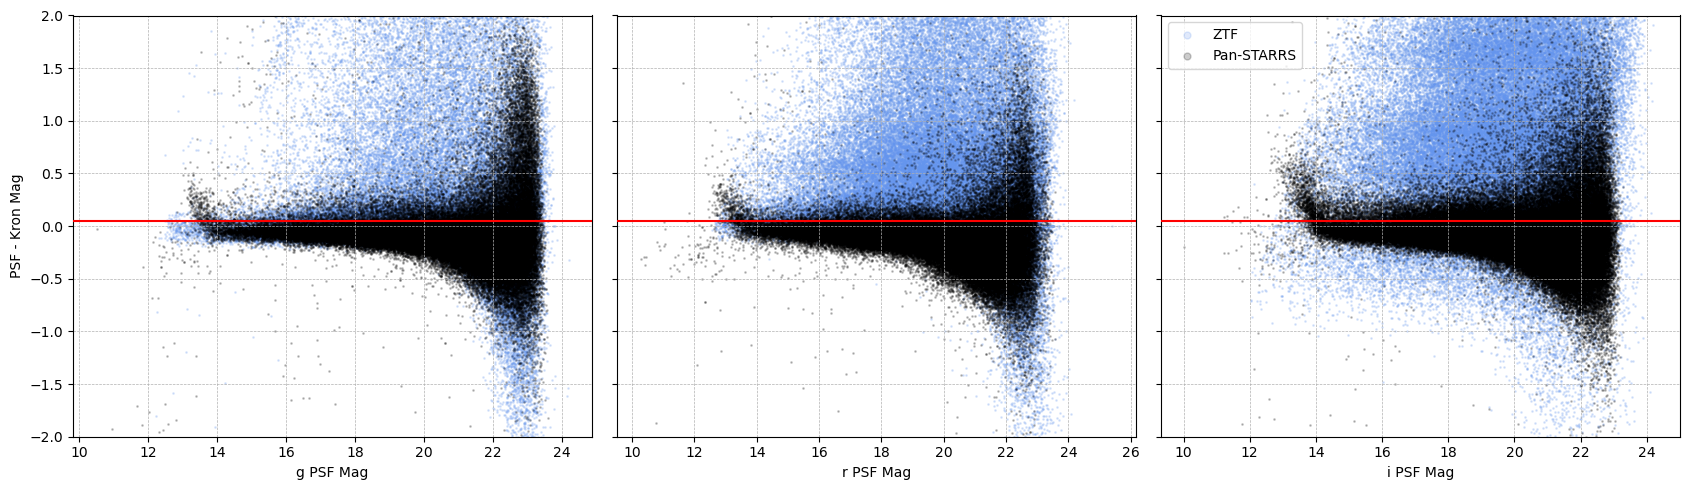

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=ZTF_ZERO_POINT[band])

    ##### BOTH #####
    # Masks
    pstarr_mask = pstarr_snr > 2
    ztf_mask = ztf_snr > 2
    ztf_mask &= (tab[f'ZTF_{band}PSFMag'] != -999) & (tab[f'ZTF_{band}PSFMagErr'] != -999) & \
        (tab[f'ZTF_{band}KronMag'] != -999) & (tab[f'ZTF_{band}KronMagErr'] != -999)
    pstarr_mask &= (tab[f'PSTARR_{band}PSFMag'] != -999) & (tab[f'PSTARR_{band}PSFMagErr'] != -999) & \
        (tab[f'PSTARR_{band}KronMag'] != -999) & (tab[f'PSTARR_{band}KronMagErr'] != -999)

    # Plot
    # Without upper lims
    ax.scatter(
        tab[ztf_mask][f'ZTF_{band}PSFMag'],
        tab[ztf_mask][f'ZTF_{band}PSFMag'] - tab[ztf_mask][f'ZTF_{band}KronMag'],
        color='cornflowerblue',
        s=1,
        label='ZTF',
        alpha=0.2
    )
    ax.scatter(
        tab[pstarr_mask][f'PSTARR_{band}PSFMag'],
        tab[pstarr_mask][f'PSTARR_{band}PSFMag'] - tab[pstarr_mask][f'PSTARR_{band}KronMag'],
        color='k',
        s=1,
        label='Pan-STARRS',
        alpha=0.2
    )

    # Formatting
    ax.axhline(0.05, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_xlabel(f'{band} PSF Mag')
    ax.set_ylim((-2, 2))

axes[0].set_ylabel(f'PSF - Kron Mag')
axes[-1].legend(markerscale=5)
plt.tight_layout()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_71277/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_71277/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


Plotting 0 / 0 upper limits
Plotting 23 / 44 upper limits
Plotting 8194 / 8440 upper limits


/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_71277/175437810.py:91: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[-1].legend(markerscale=5)


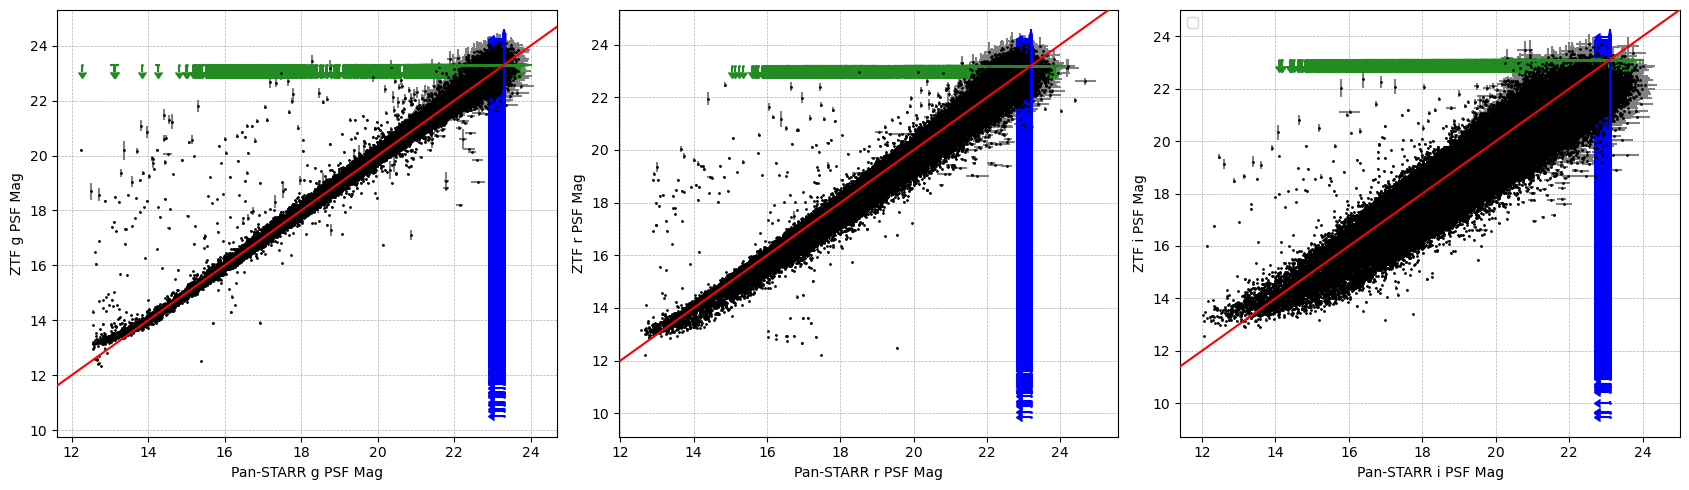

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=ZTF_ZERO_POINT[band])

    ##### BOTH #####
    # Masks
    both_mask = (tab['Catalog'] == 'Both') & (tab[f'PSTARR_{band}PSFMag'] != -999)
    ztf_upper_lim_mask = tab[f'ZTF_{band}_upper_lim']

    # Plot
    # Without upper lims
    mask = both_mask & (pstarr_snr > 3) & (ztf_snr > 3) & ~ztf_upper_lim_mask
    ax.errorbar(
        tab[mask][f'ZTF_{band}PSFMag'],
        tab[mask][f'PSTARR_{band}PSFMag'],
        xerr=tab[mask][f'ZTF_{band}PSFMagErr'],
        yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
        color='k',
        linestyle="None",
        fmt="o",
        markersize=1,
        ecolor='gray',
    )
    # Just upper lims
    mask = both_mask & (pstarr_snr > 3) & ztf_upper_lim_mask
    print(f'Plotting {np.sum(mask)} / {np.sum(ztf_upper_lim_mask)} upper limits')
    ax.errorbar(
        tab[mask][f'ZTF_{band}PSFMag'],
        tab[mask][f'PSTARR_{band}PSFMag'],
        xerr=[0.25 for _ in range(np.sum(mask))],
        yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
        xuplims=True,
        color='k',
        linestyle="None",
        fmt="o",
        markersize=1,
        ecolor='gray',
    )

    ##### Only in PSTARR #####
    # Mask
    pstarr_mask = (tab['Catalog'] == 'PSTARR') & (tab[f'PSTARR_{band}PSFMag'] != -999) & (tab[f'PSTARR_{band}PSFMagErr'] != -999)
    mask = pstarr_mask & (pstarr_snr > 3)

    # Plot
    upper_lims = [UPPER_LIMIT_MAGS['ztf'][band] for _ in range(np.sum(mask))]
    ax.errorbar(
        upper_lims,
        tab[mask][f'PSTARR_{band}PSFMag'],
        xerr=[0.25 for _ in range(len(upper_lims))],
        yerr=tab[mask][f'PSTARR_{band}PSFMagErr'],
        xuplims=True,
        color='blue',
        linestyle="None",
        fmt="o",
        markersize=1,
    )

    ##### Only in ZTF #####
    # Mask
    ztf_mask = (tab['Catalog'] == 'ZTF')
    mask = ztf_mask & (ztf_snr > 3)

    # Plot
    upper_lims = [UPPER_LIMIT_MAGS['pstarr'][band] for _ in range(np.sum(mask))]
    ax.errorbar(
        tab[mask][f'ZTF_{band}PSFMag'],
        upper_lims,
        yerr=[0.25 for _ in range(len(upper_lims))],
        xerr=tab[mask][f'ZTF_{band}PSFMagErr'],
        uplims=True,
        color='forestgreen',
        linestyle="None",
        fmt="o",
        markersize=1,
    )

    # Formatting
    ax.axline((15, 15), slope=1, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_ylabel(f'ZTF {band} PSF Mag')
    ax.set_xlabel(f'Pan-STARR {band} PSF Mag')

axes[-1].legend(markerscale=5)
plt.tight_layout()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_71277/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_71277/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


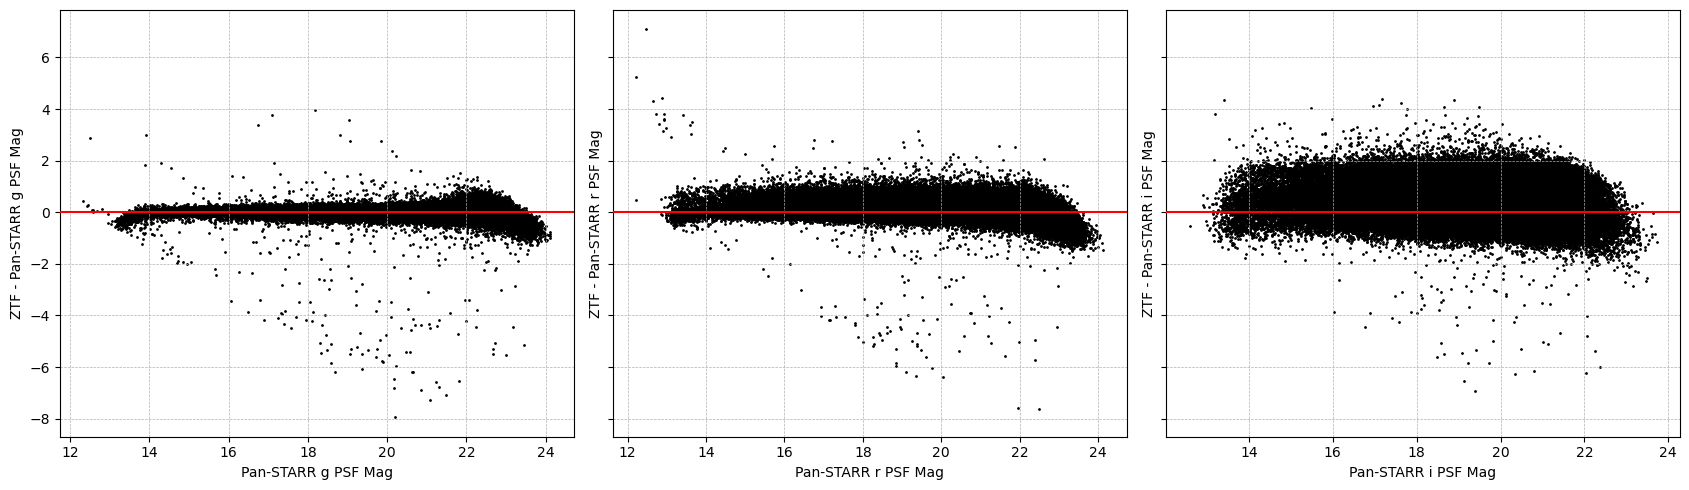

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=ZTF_ZERO_POINT[band])

    ##### BOTH #####
    # Masks
    snr_mask = (pstarr_snr > 3) & (ztf_snr > 3)
    both_mask = (tab['Catalog'] == 'Both') & (tab[f'PSTARR_{band}PSFMag'] != -999)

    # Plot
    mask = both_mask & snr_mask
    ax.scatter(
        tab[mask][f'PSTARR_{band}PSFMag'],
        tab[mask][f'ZTF_{band}PSFMag'] - tab[mask][f'PSTARR_{band}PSFMag'],
        color='k',
        s=1,
    )

    # Formatting
    ax.axhline(0, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_ylabel(f'ZTF - Pan-STARR {band} PSF Mag')
    ax.set_xlabel(f'Pan-STARR {band} PSF Mag')

ylims = np.array([ax.get_ylim() for ax in axes])
for ax in axes:
    ax.set_ylim(np.min(ylims), np.max(ylims))

plt.tight_layout()
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_71277/2294796586.py:5: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_71277/2294796586.py:13: RuntimeWarning: invalid value encountered in divide
  return flux / fluxerr


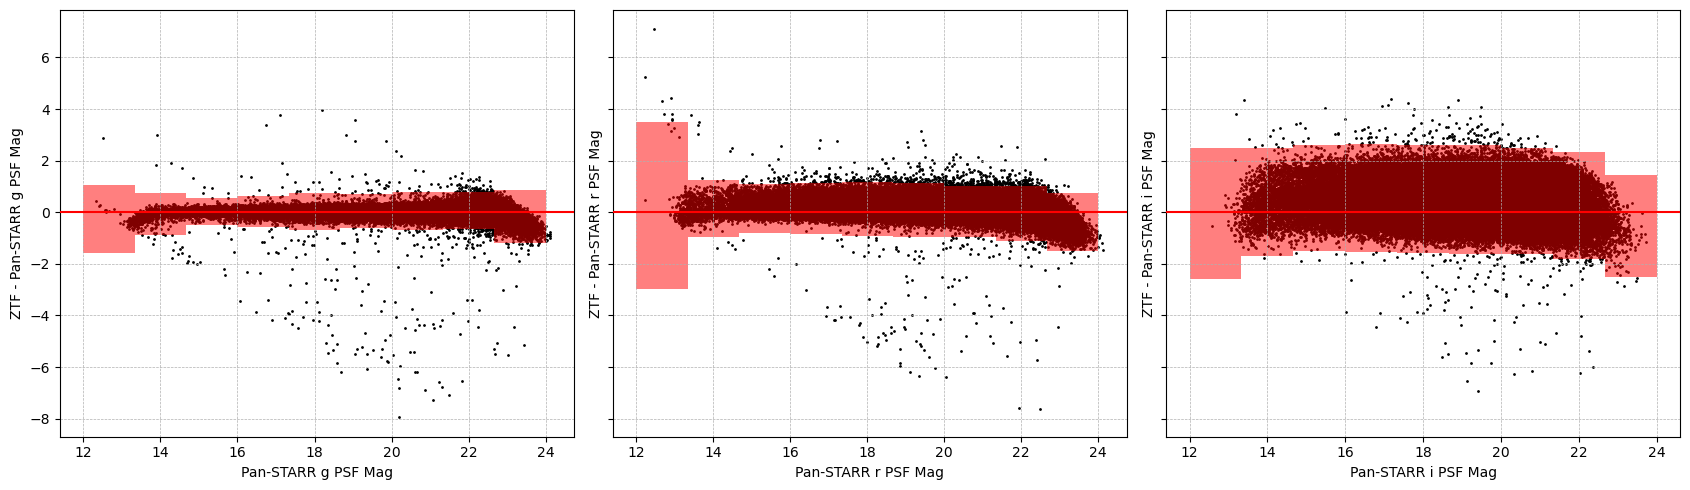

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)

for ax, band in zip(axes.flatten(), BANDS):

    # Get the band's table 
    tab = tables[band]

    # Calculate SNRs
    pstarr_snr = get_snr_from_mag(tab[f'PSTARR_{band}PSFMag'], tab[f'PSTARR_{band}PSFMagErr'], zp=25)  #TODO: Check zero points
    ztf_snr = get_snr_from_mag(tab[f'ZTF_{band}PSFMag'], tab[f'ZTF_{band}PSFMagErr'], zp=ZTF_ZERO_POINT[band])

    ##### BOTH #####
    # Masks
    snr_mask = (pstarr_snr > 3) & (ztf_snr > 3)
    both_mask = (tab['Catalog'] == 'Both') & (tab[f'PSTARR_{band}PSFMag'] != -999)
    mask = both_mask & snr_mask

    # Get the 3-sigma boundaries on delta mag
    mag_bin_edges = np.linspace(12, 24, num=10)
    bin_means, bin_stds = [], []
    for i in range(len(mag_bin_edges) - 1):
        lower, upper = mag_bin_edges[i], mag_bin_edges[i+1]
        bin_mask = both_mask & snr_mask & (tab[f'PSTARR_{band}PSFMag'] > lower) & (tab[f'PSTARR_{band}PSFMag'] < upper)

        bin_means.append(np.mean(tab[bin_mask][f"ZTF_{band}PSFMag"] - tab[bin_mask][f"PSTARR_{band}PSFMag"]))
        bin_stds.append(np.std(tab[bin_mask][f"ZTF_{band}PSFMag"] - tab[bin_mask][f"PSTARR_{band}PSFMag"]))

    # Plot
    ax.scatter(
        tab[mask][f'PSTARR_{band}PSFMag'],
        tab[mask][f'ZTF_{band}PSFMag'] - tab[mask][f'PSTARR_{band}PSFMag'],
        color='k',
        s=1,
    )

    # Plot the bin mean +- 3sigma with rectangles for each bin
    for lower, upper, mean, std in zip(mag_bin_edges[:-1], mag_bin_edges[1:], bin_means, bin_stds):
        rect = plt.Rectangle(
            (lower, mean - (3 * std)),
            upper - lower,
            6 * std,
            color='red',
            alpha=0.5,
            lw=0,
        )
        ax.add_patch(rect)

    # Formatting
    ax.axhline(0, color='red', zorder=10)
    ax.grid(lw=0.5, ls='--')
    ax.set_ylabel(f'ZTF - Pan-STARR {band} PSF Mag')
    ax.set_xlabel(f'Pan-STARR {band} PSF Mag')

ylims = np.array([ax.get_ylim() for ax in axes])
for ax in axes:
    ax.set_ylim(np.min(ylims), np.max(ylims))

plt.tight_layout()
plt.show()